In [1]:
import os
import rasterio
from rasterio import plot
import matplotlib.pyplot as plt
import numpy as np
from osgeo import gdal
from gdalconst import *
from scipy import stats

%matplotlib inline

In [2]:
os.listdir('../bireyselrasterio/veriseti')

['2014_B6.tif', '2014_B7.tif', '2019_B6.tif', '2019_B7.tif']

In [3]:
band6 = rasterio.open('../bireyselrasterio/veriseti/2019_B6.tif') #SWIR1
band7 = rasterio.open('../bireyselrasterio/veriseti/2019_B7.tif') #SWIR2

In [4]:
#Band 6 Height & Width
band6_height=band6.height
band6_width=band6.width
print("band6 height=",band6_height,"band6 width=",band6_width)
#Band 7 Height & Width
band7_height=band7.height
band7_width=band7.width
print("band7 height=",band7_height,"band7 width=",band7_width)

band6 height= 476 band6 width= 701
band7 height= 476 band7 width= 701


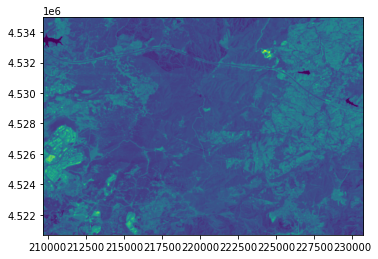

<AxesSubplot:>

In [5]:
plot.show(band6)

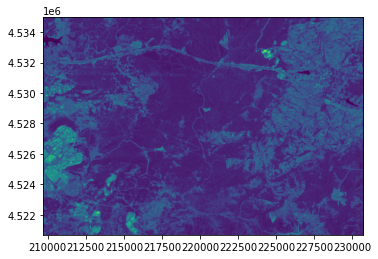

<AxesSubplot:>

In [6]:
plot.show(band7)

In [7]:
#type of raster byte
band6.dtypes[0],band7.dtypes[0]

('uint16', 'uint16')

In [8]:
#raster sytem of reference
crs=(band6.crs, band7.crs)
print(crs)
print("WGS 84 / UTM zone 36N - EPSG:32636")

(CRS.from_epsg(32636), CRS.from_epsg(32636))
WGS 84 / UTM zone 36N - EPSG:32636


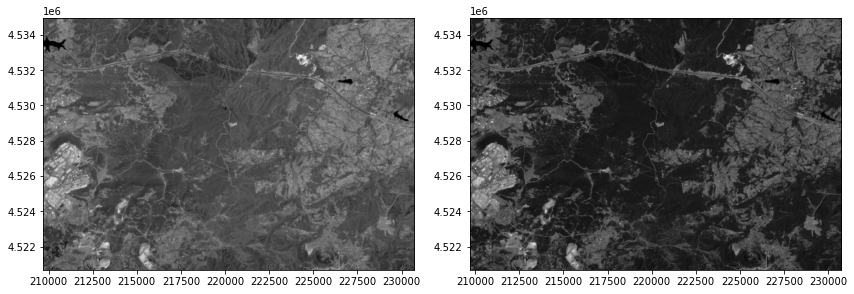

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

plot.show(band6, ax=ax1, cmap='Greys_r') #SWIR1
plot.show(band7, ax=ax2, cmap='Greys_r') #SWIR2
fig.tight_layout()

In [10]:
#generate SWIR1 and SWIR2 objects as arrays in float64 format

SWIR1 = band6.read(1).astype('float64')
SWIR2 = band7.read(1).astype('float64')


In [11]:
#NDTI calculation, empty cells or nodata cells are reported as 0
NDTI=np.where(
    (SWIR1+SWIR2)==0., 
    0, 
    (SWIR1-SWIR2)/(SWIR1+SWIR2))
NDTI[:5,:5]
#export NDTI image
NDTIImage = rasterio.open('../bireyselrasterio/Output/NDTI_2019.tif','w',driver='Gtiff',
                          width=band6.width, 
                          height = band6.height, 
                          count=1, crs=band6.crs, 
                          transform=band6.transform, 
                          dtype='float64')
NDTIImage.write(NDTI,1)
NDTIImage.close()

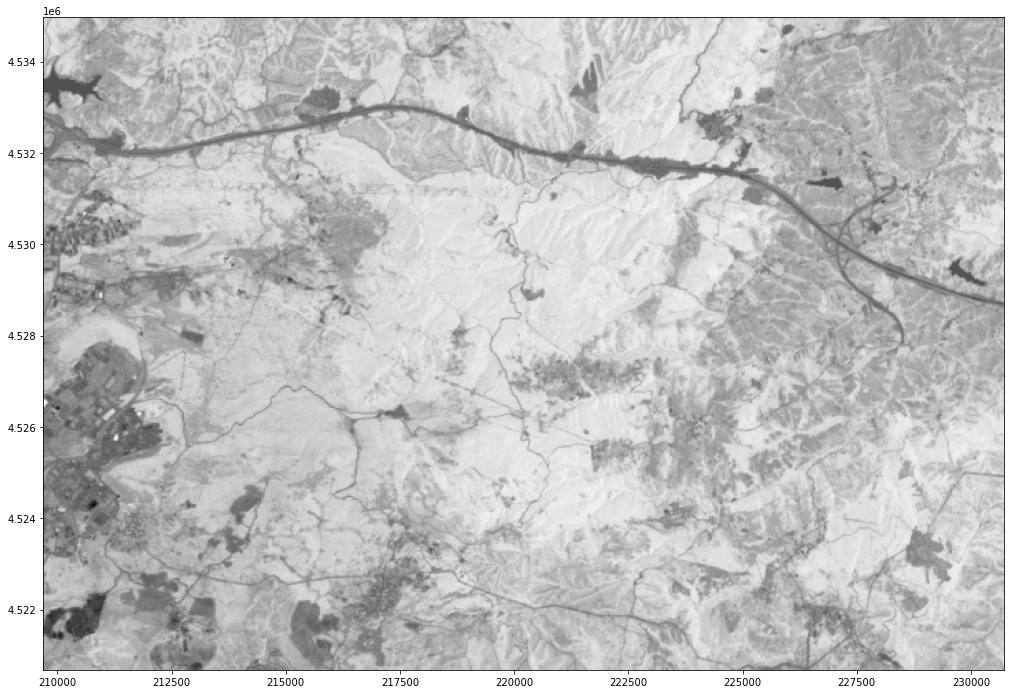

<AxesSubplot:>

In [12]:
#plot NDTI
NDTI = rasterio.open('../bireyselrasterio/Output/NDTI_2019.tif')
fig = plt.figure(figsize=(18,12))
plot.show(NDTI, cmap='gray')

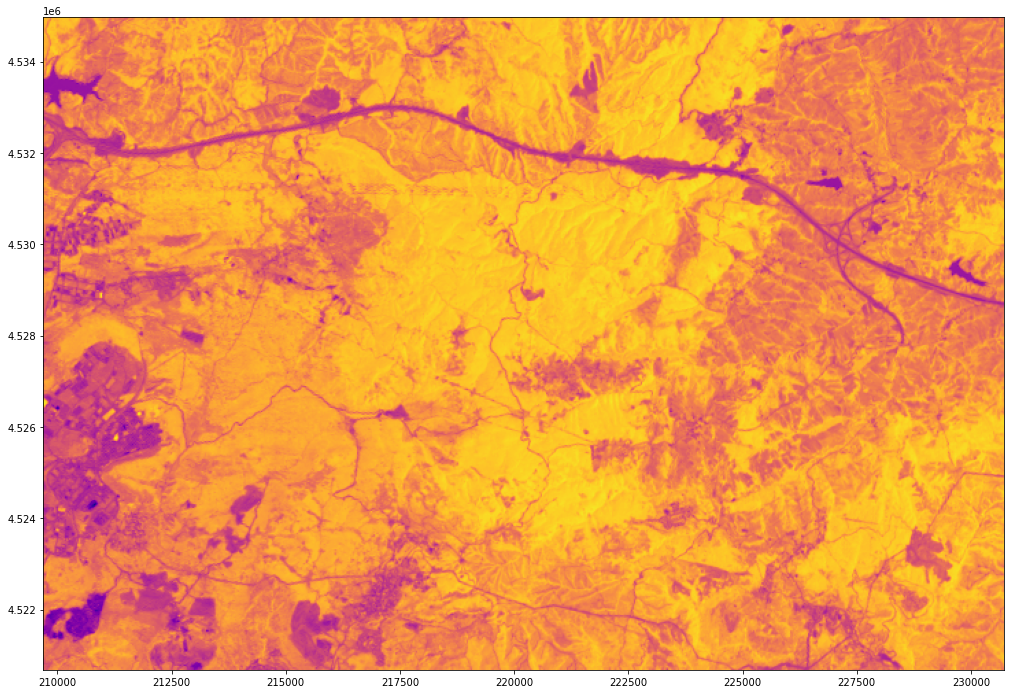

<AxesSubplot:>

In [13]:
#plot NDTI
NDTI = rasterio.open('../bireyselrasterio/Output/NDTI_2019.tif')
fig = plt.figure(figsize=(18,12))
plot.show(NDTI, cmap='plasma')

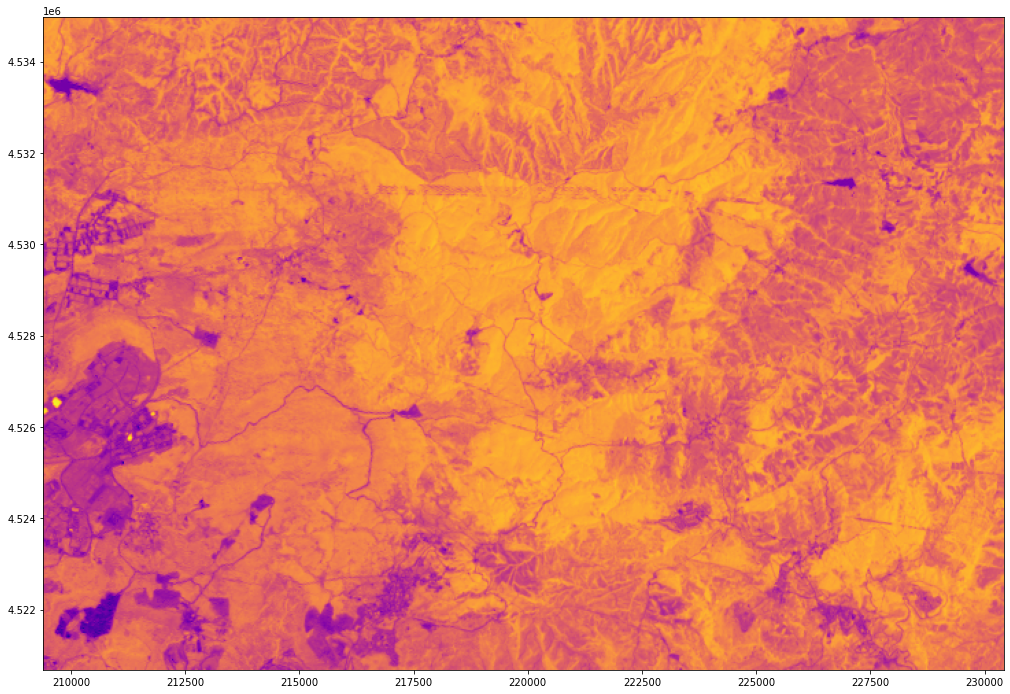

<AxesSubplot:>

In [14]:
#plot NDTI
NDTI = rasterio.open('../bireyselrasterio/Output/NDTI_2014.tif')
fig = plt.figure(figsize=(18,12))
plot.show(NDTI, cmap='plasma')

In [15]:
os.listdir('../bireyselrasterio/output')

['NBI.tif',
 'NBI.tif.aux.xml',
 'NDBI.tif',
 'NDBI.tif.aux.xml',
 'NDTI.tif',
 'NDTI.tif.aux.xml',
 'NDTI_2014.tif',
 'NDTI_2014.tif.aux.xml',
 'NDTI_2019.tif',
 'NDVI.tif',
 'NDVI.tif.aux.xml']

In [16]:
filename_t1 = "../bireyselrasterio/output/NDTI_2019.tif"
filename_t2 = "../bireyselrasterio/output/NDTI_2014.tif"

In [17]:
rows = 476
columns = 701
figure_border = 25
# load the datasets
dataset_t1 = gdal.Open(filename_t1, GA_ReadOnly) 
dataset_t2 = gdal.Open(filename_t2, GA_ReadOnly) 
# get the reference for the first bands of t1 and t2
ndti_t1 = dataset_t1.GetRasterBand(1)
ndti_t2 = dataset_t2.GetRasterBand(1)

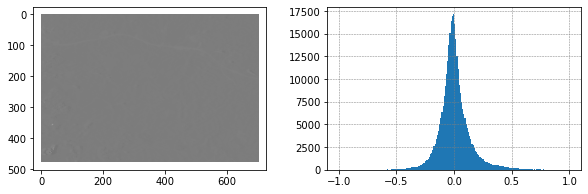

In [18]:
array_t1 = ndti_t1.ReadAsArray()[0:rows, 0:columns].astype(float)
array_t2 = ndti_t2.ReadAsArray()[0:rows, 0:columns].astype(float)
array_ndtidif = (array_t2 - array_t1) / (array_t2 + array_t1)
# create figure to display original ndtidif= NDTI difference
output_fig, (ndtidif_ax, histogram_ax) = plt.subplots(figsize=(10, 3), ncols=2)
ndtidif_ax.imshow(array_ndtidif, cmap="gray")
ndtidif_ax.set_xlim([0 - figure_border, columns + figure_border])
ndtidif_ax.set_ylim([rows + figure_border, 0 - figure_border])
histogram_ax.hist(array_ndtidif.ravel(), bins=200, range=(-1.0, 1.0))
histogram_ax.grid(b=True, color='gray', linestyle='--', linewidth=0.5);
output_fig.savefig("ndtidif.png", format='png', dpi=200)
plt.show()

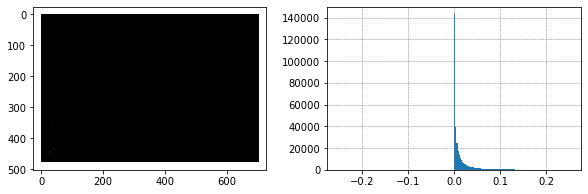

In [19]:
# compute square of ndtidif
array_square_ndtidif = array_ndtidif * array_ndtidif
# create figure to display square of ndtidif
output_fig, (square_ndtidif_ax, histogram_ax) = plt.subplots(figsize=(10, 3), ncols=2)
square_ndtidif_ax.imshow(array_square_ndtidif, cmap="gray")
square_ndtidif_ax.set_xlim([0 - figure_border, columns + figure_border])
square_ndtidif_ax.set_ylim([rows + figure_border, 0 - figure_border])

histogram_ax.hist(array_square_ndtidif.ravel(), bins=200, range=(-0.25, 0.25))
histogram_ax.grid(b=True, color='gray', linestyle='--', linewidth=0.5);
output_fig.savefig("square_ndtidif.png", format='png', dpi=200)
plt.show()

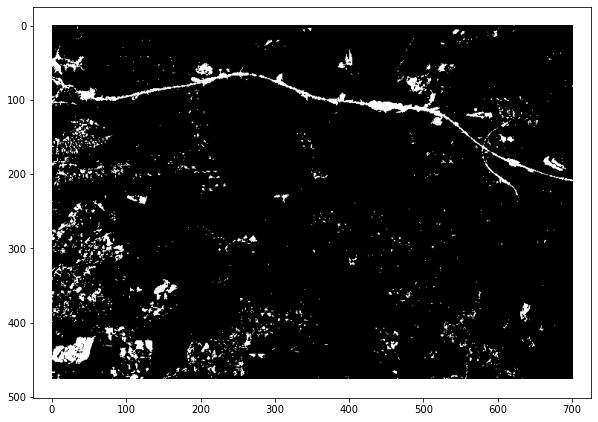

In [20]:
# apply threshold to highlight change detection
threshold = 0.1
threshold_array_square_ndtidif = array_square_ndtidif > threshold
# create figure to display change detection
output_fig, threshold_ax = plt.subplots(figsize=(10, 8), ncols=1)
threshold_ax.imshow(threshold_array_square_ndtidif, cmap="gray")
threshold_ax.set_xlim([0 - figure_border, columns + figure_border])
threshold_ax.set_ylim([rows + figure_border, 0 - figure_border])
output_fig.savefig("threshold_square_ndtidif.png", format='png', dpi=200)
plt.show()

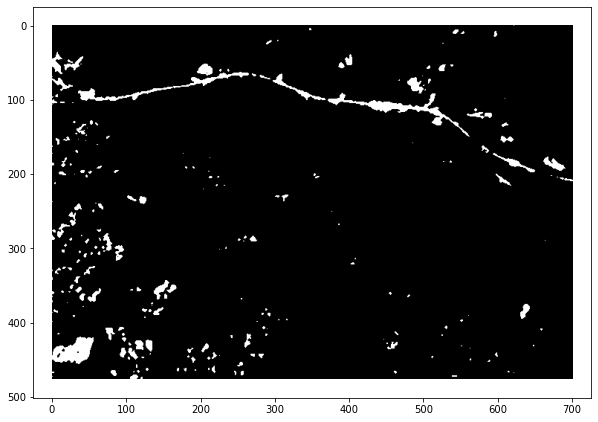

In [21]:
# apply 3x3 mode filter to remove noise
mode_threshold_array_square_ndtidif = threshold_array_square_ndtidif
for i in range(1,rows):
	for j in range(1,columns):
		values = np.array(threshold_array_square_ndtidif[i-1:i+2, j-1:j+2])
		mode_threshold_array_square_ndtidif[i, j] = stats.mode(values.ravel())[0][0]
# create figure to display filtered change detection
output_fig, threshold_ax = plt.subplots(figsize=(10, 8), ncols=1)
threshold_ax.imshow(mode_threshold_array_square_ndtidif, cmap="gray")
threshold_ax.set_xlim([0 - figure_border, columns + figure_border])
threshold_ax.set_ylim([rows + figure_border, 0 - figure_border])
output_fig.savefig("mode_threshold_square_ndtidif.png", format='png', dpi=200)
plt.show()